In [274]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import seaborn as sns
import lightgbm as lgb
np.random.seed(587)

In [122]:
df = pd.read_csv('WA_Fn-UseC_-Accounts-Receivable.csv')

In [123]:
df.head()

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate
0,391,0379-NEVHP,4/6/2013,611365,1/2/2013,2/1/2013,55.94,No,1/15/2013,Paper,13,0
1,406,8976-AMJEO,3/3/2012,7900770,1/26/2013,2/25/2013,61.74,Yes,3/3/2013,Electronic,36,6
2,391,2820-XGXSB,1/26/2012,9231909,7/3/2013,8/2/2013,65.88,No,7/8/2013,Electronic,5,0
3,406,9322-YCTQO,4/6/2012,9888306,2/10/2013,3/12/2013,105.92,No,3/17/2013,Electronic,35,5
4,818,6627-ELFBK,11/26/2012,15752855,10/25/2012,11/24/2012,72.27,Yes,11/28/2012,Paper,34,4


In [33]:
df.shape

(2466, 12)

In [34]:
df.columns

Index(['countryCode', 'customerID', 'PaperlessDate', 'invoiceNumber',
       'InvoiceDate', 'DueDate', 'InvoiceAmount', 'Disputed', 'SettledDate',
       'PaperlessBill', 'DaysToSettle', 'DaysLate'],
      dtype='object')

In [35]:
df.isnull().sum()

countryCode      0
customerID       0
PaperlessDate    0
invoiceNumber    0
InvoiceDate      0
DueDate          0
InvoiceAmount    0
Disputed         0
SettledDate      0
PaperlessBill    0
DaysToSettle     0
DaysLate         0
dtype: int64

In [124]:
df[['ElectronicBill','disputed']] = pd.get_dummies(df[['PaperlessBill', 'Disputed']])[['PaperlessBill_Electronic','Disputed_Yes']]

In [127]:
df[['391','406','770','818','897']] = pd.get_dummies(df['countryCode'])

In [175]:
df.head()

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate,ElectronicBill,disputed,391,406,770,818,897,Late
0,391,0379-NEVHP,4/6/2013,611365,1/2/2013,2/1/2013,55.94,No,1/15/2013,Paper,13,0,0,0,1,0,0,0,0,0
1,406,8976-AMJEO,3/3/2012,7900770,1/26/2013,2/25/2013,61.74,Yes,3/3/2013,Electronic,36,6,1,1,0,1,0,0,0,1
2,391,2820-XGXSB,1/26/2012,9231909,7/3/2013,8/2/2013,65.88,No,7/8/2013,Electronic,5,0,1,0,1,0,0,0,0,0
3,406,9322-YCTQO,4/6/2012,9888306,2/10/2013,3/12/2013,105.92,No,3/17/2013,Electronic,35,5,1,0,0,1,0,0,0,1
4,818,6627-ELFBK,11/26/2012,15752855,10/25/2012,11/24/2012,72.27,Yes,11/28/2012,Paper,34,4,0,1,0,0,0,1,0,1


In [174]:
df['Late'] = [1 if x>0 else 0 for x in df['DaysLate']]

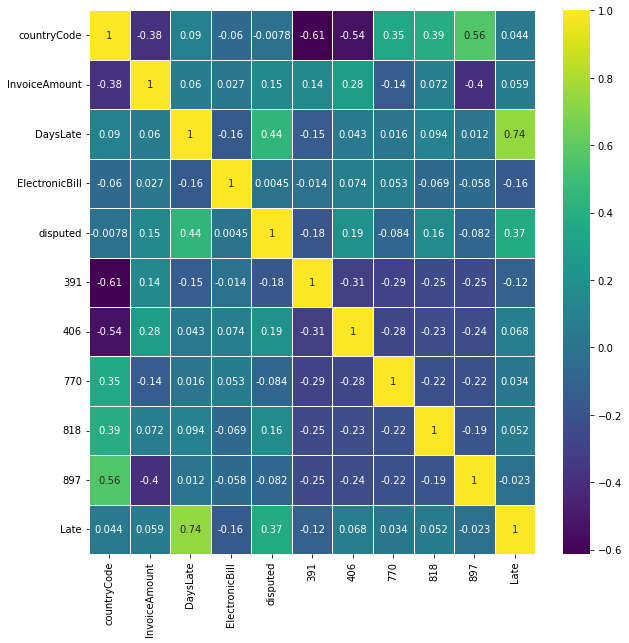

In [177]:
corremat = df.drop(['customerID','PaperlessDate','invoiceNumber',
                    'DueDate','SettledDate','DaysToSettle', 'InvoiceDate'], axis = 1).corr()
plt.figure(figsize=(10,10))
g= sns.heatmap(corremat,annot=True,cmap='viridis',linewidths=.5)

In [129]:
df.columns

Index(['countryCode', 'customerID', 'PaperlessDate', 'invoiceNumber',
       'InvoiceDate', 'DueDate', 'InvoiceAmount', 'Disputed', 'SettledDate',
       'PaperlessBill', 'DaysToSettle', 'DaysLate', 'ElectronicBill',
       'disputed', '391', '406', '770', '818', '897'],
      dtype='object')

In [249]:
x_train,x_test, y_train,y_test = train_test_split(df.drop(['customerID','PaperlessDate','invoiceNumber','countryCode',
                                                          'DueDate','SettledDate', 'InvoiceDate',
                                                          'Disputed','PaperlessBill','DaysLate'], axis = 1),
                                                 df['DaysLate'], test_size = 0.33)

In [250]:
x_train_train, x_val, y_train_train, y_val = train_test_split(x_train, y_train, test_size = 0.33)

In [251]:
x_train_train.head()

,InvoiceAmount,DaysToSettle,ElectronicBill,disputed,391,406,770,818,897,Late
1979,99.22,45,1,0,1,0,0,0,0,1
520,83.02,23,1,0,0,0,0,1,0,0
730,45.51,17,0,0,0,1,0,0,0,0
4,72.27,34,0,1,0,0,0,1,0,1
746,56.82,32,1,0,0,0,1,0,0,1


In [252]:
#clf = make_pipeline(StandardScaler(), LinearRegression())
clf = LinearRegression()

In [253]:
clf.fit(x_train_train, y_train_train)

LinearRegression()

In [254]:
y_train_train.shape

(1106,)

In [255]:
train_pred = clf.predict(x_train_train)
val_pred = clf.predict(x_val)


In [256]:
mean_squared_error(y_val, val_pred)

11.084887042398355

In [257]:
mean_squared_error(y_train_train, train_pred)

11.6664021896295

In [258]:
clf.coef_

array([ 0.00358566,  0.2746983 ,  0.14687663,  2.1646852 ,  0.00899988,
       -0.65730046, -0.3362501 ,  0.33513135,  0.64941933,  3.44730371])

In [259]:
x_train_train.columns

Index(['InvoiceAmount', 'DaysToSettle', 'ElectronicBill', 'disputed', '391',
       '406', '770', '818', '897', 'Late'],
      dtype='object')

In [260]:
clf.score(x_train_train, y_train_train)

0.7068630645761205

In [261]:
clf.score(x_val, y_val)

0.6827184828539141

## gradient boosting regressor

In [262]:
reg = GradientBoostingRegressor()
reg.fit(x_train_train, y_train_train)

GradientBoostingRegressor()

In [263]:
reg.score(x_train_train, y_train_train)

0.9999999788376217

In [264]:
reg.score(x_val, y_val)

0.999944233218719

In [265]:
mean_squared_error(reg.predict(x_val), y_val)

0.0019483280235756356

## Random Forest Regressor

In [266]:
RFR = RandomForestRegressor(n_estimators = 1000)
RFR.fit(x_train_train, y_train_train)

RandomForestRegressor(n_estimators=1000)

In [267]:
mean_squared_error(RFR.predict(x_val), y_val)

0.0016615549450549507

In [268]:
RFR.score(x_val, y_val)

0.9999524414933799

## Lightgbm Regressor

In [269]:
fit_params={"early_stopping_rounds":30,
            "eval_metric" : 'auc',
            "eval_set" : [(x_val,y_val)],
            'eval_names': ['valid'],
            'verbose': 100,
            'feature_name': 'auto', # that's actually the default
            'categorical_feature': 'auto' # that's actually the default
           }

clf = lgb.LGBMRegressor(max_depth=7,
                        boosting_type='gbdt',
                         n_jobs=10,
                         n_estimators=1000,
                         feature_fraction = 0.6,
                         bagging_fraction = 0.6,
                         learning_rate=0.1)


In [270]:
clf.fit(x_train_train, y_train_train)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


LGBMRegressor(bagging_fraction=0.6, feature_fraction=0.6, max_depth=7,
              n_estimators=1000, n_jobs=10)

In [271]:
clf.score(x_val, y_val)

0.9915170464936961

## running a cross validation to see the average scores

In [277]:
n_splits = 5
kf = KFold(n_splits, shuffle = True)
i = 0
scores = np.zeros((5,3))
for train_index, test_index in kf.split(x_train, y_train):
    x_train_cv = x_train.iloc[train_index]
    y_train_cv = y_train.iloc[train_index]
    x_test_cv = x_train.iloc[test_index]
    y_test_cv = y_train.iloc[test_index]

    LR = LinearRegression()
    reg = GradientBoostingRegressor()
    clf = lgb.LGBMRegressor(max_depth=7,
                        boosting_type='gbdt',
                         n_jobs=10,
                         n_estimators=1000,
                         feature_fraction = 0.6,
                         bagging_fraction = 0.6,
                         learning_rate=0.1)
    LR.fit(x_train_cv,y_train_cv)
    reg.fit(x_train_cv,y_train_cv)
    clf.fit(x_train_cv, y_train_cv)
    scores[i,0] = LR.score(x_test_cv, y_test_cv)
    scores[i,1] = reg.score(x_test_cv, y_test_cv)
    scores[i,2] = clf.score(x_test_cv, y_test_cv)
    i = i + 1

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fractio

In [278]:
scores

array([[0.63923492, 1.        , 0.9948163 ],
       [0.68479494, 0.99991174, 0.99790303],
       [0.69308698, 0.99999962, 0.9923079 ],
       [0.68805359, 0.99999955, 0.99326551],
       [0.71769125, 0.99895312, 0.98383206]])

In [283]:
# It seems that GradientBoostingRegressor has the best score
scores.mean(axis = 0)

array([0.68457233, 0.99977281, 0.99242496])